# Baseline CNN Model

> [A Brief Introduction to Satellite Image Segmentation with Neural Networks](https://medium.com/@robmarkcole/a-brief-introduction-to-satellite-image-segmentation-with-neural-networks-33ea732d5bce)

In [1]:
# ignore warning messages
import warnings

warnings.filterwarnings("ignore")

# for data processing
import pandas as pd
import numpy as np

# for image processing & viz
import skimage
from PIL import Image, ImageDraw, ImageColor
from IPython.display import display
import matplotlib.pyplot as plt

# for environment variables
import os

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
pd.set_option("display.max_columns", None)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.get_logger().setLevel('ERROR')

assert (
    tf.__version__ == "2.15.0"
), "Tensorflow must be version 2.15.0 in order to access EC2 g4dn T4 GPU"

### Check GPU Status

In [4]:
!nvidia-smi

Thu Mar 21 20:03:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:00:1E.0 Off |                    0 |
| N/A   18C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
(
    print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
    if tf.test.gpu_device_name()
    else print("Please install GPU version of TF")
)

Default GPU Device: /device:GPU:0


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [7]:
MAIN_DATA_DIR: str = "/home/jupyter-jhub-admin/data/xview2"
CHALLENGE_DATA_DIR: str = MAIN_DATA_DIR + "/challenge"
PROCESSED_DATA_DIR: str = MAIN_DATA_DIR + "/processed"
MASKS_DATA_DIR: str = MAIN_DATA_DIR + "/masks"

print(f"{CHALLENGE_DATA_DIR=}")
print(f"{PROCESSED_DATA_DIR=}")
print(f"{MASKS_DATA_DIR=}")

CHALLENGE_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/challenge'
PROCESSED_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/processed'
MASKS_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/masks'


In [8]:
img_meta_df = pd.read_parquet(f"{PROCESSED_DATA_DIR}/images.parquet")

# Declaring Image path
img_meta_df["image_path"] = (
    CHALLENGE_DATA_DIR
    + "/"
    + img_meta_df["dataset"]
    + "/images/"
    + img_meta_df["img_name"]
)

# Filtering only hurricane disasters in scope of this project
img_meta_df = img_meta_df[img_meta_df["disaster_sub_type"] == "hurricane"]

required_img_columns: list[str] = [
    "disaster",
    "disaster_type",
    "disaster_sub_type",
    "width",
    "height",
    "dataset",
    "image_id",
    "is_pre_image",
    "id",
    "building_count",
    "image_path",
]

img_meta_df = img_meta_df[required_img_columns]

print(img_meta_df.shape)
print(img_meta_df.iloc[0]["image_path"])
img_meta_df.head()

(4046, 11)
/home/jupyter-jhub-admin/data/xview2/challenge/hold/images/hurricane-matthew_00000012_pre_disaster.png


,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,id,building_count,image_path
0,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,/home/jupyter-jhub-admin/data/xview2/challenge...
1,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000015,True,MjU4MzkzNQ.eGkpU6lYXd1co5g1a8Kqa0GnF_M,3,/home/jupyter-jhub-admin/data/xview2/challenge...
2,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000020,True,MjU4Mzk2Mw.qyhEB0t3wday68p_qqZuIJ0LBbs,86,/home/jupyter-jhub-admin/data/xview2/challenge...
3,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000024,True,MjU4Mzk4Mg.xwQHzF2LEQxSVC3oi7-Dm-UvlSc,333,/home/jupyter-jhub-admin/data/xview2/challenge...
4,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000025,True,MjU4Mzk4NQ.RsNC-j-lQcImj6XqruNjCofqYJw,34,/home/jupyter-jhub-admin/data/xview2/challenge...


In [9]:
mask_df = img_meta_df[img_meta_df["is_pre_image"] == True].reset_index(drop=True)
mask_df["image_path"] = mask_df["image_path"].apply(
    lambda cell: cell.replace("/challenge/", "/masks/").replace(
        "_pre_disaster.png", ".png"
    )
)
print(mask_df.shape)
mask_df.head()

(2023, 11)


,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,id,building_count,image_path
0,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,/home/jupyter-jhub-admin/data/xview2/masks/hol...
1,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000015,True,MjU4MzkzNQ.eGkpU6lYXd1co5g1a8Kqa0GnF_M,3,/home/jupyter-jhub-admin/data/xview2/masks/hol...
2,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000020,True,MjU4Mzk2Mw.qyhEB0t3wday68p_qqZuIJ0LBbs,86,/home/jupyter-jhub-admin/data/xview2/masks/hol...
3,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000024,True,MjU4Mzk4Mg.xwQHzF2LEQxSVC3oi7-Dm-UvlSc,333,/home/jupyter-jhub-admin/data/xview2/masks/hol...
4,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000025,True,MjU4Mzk4NQ.RsNC-j-lQcImj6XqruNjCofqYJw,34,/home/jupyter-jhub-admin/data/xview2/masks/hol...


Check if images from both paths are readable

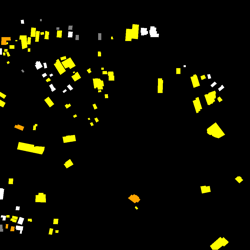

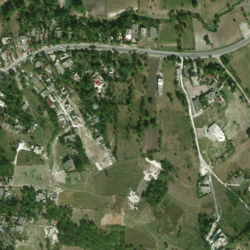

In [10]:
display(Image.open(mask_df.iloc[0]["image_path"]).resize(size=(250, 250)))
display(Image.open(img_meta_df.iloc[0]["image_path"]).resize(size=(250, 250)))

Filter training data and add masks for pre and post images

In [11]:
train_df: pd.DataFrame = img_meta_df[img_meta_df["dataset"].isin(["train", "hold"])]

train_df = train_df[train_df.building_count > 10]

train_df = train_df.merge(
    mask_df[["image_id", "image_path"]].rename(columns={"image_path": "mask_path"}),
    "left",
    "image_id",
)

print(train_df.shape)
train_df.head()

(2366, 12)


,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,id,building_count,image_path,mask_path
0,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/hol...
1,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000020,True,MjU4Mzk2Mw.qyhEB0t3wday68p_qqZuIJ0LBbs,86,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/hol...
2,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000024,True,MjU4Mzk4Mg.xwQHzF2LEQxSVC3oi7-Dm-UvlSc,333,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/hol...
3,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000025,True,MjU4Mzk4NQ.RsNC-j-lQcImj6XqruNjCofqYJw,34,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/hol...
4,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000026,True,MjU4Mzk4Ng.SN5VMlkiC4G-377BK-v2z_vxcAs,143,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/hol...


In [12]:
pre_img_train_df = train_df[train_df.is_pre_image].sort_values(by=['image_id'])
post_img_train_df = train_df[~train_df.is_pre_image].sort_values(by=['image_id'])

print(pre_img_train_df.shape)
print(post_img_train_df.shape)

(1183, 12)
(1183, 12)


In [13]:
pre_img_train_df.head()

,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,id,building_count,image_path,mask_path
1732,hurricane-florence,flooding,hurricane,1024,1024,train,hurricane-florence_00000000,True,MjM1MzgyMQ.z_IkSOE9jq-Tlkz3qP3zroVakwI,110,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/tra...
1733,hurricane-florence,flooding,hurricane,1024,1024,train,hurricane-florence_00000001,True,MjM1Mzg0MA.yGp64zFNkJ918WOMNdq3Vc8el-4,91,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/tra...
1734,hurricane-florence,flooding,hurricane,1024,1024,train,hurricane-florence_00000003,True,MjM1Mzg2NA.fkcLNttmGNsiZcrL02JOA_src7c,66,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/tra...
1725,hurricane-florence,flooding,hurricane,1024,1024,hold,hurricane-florence_00000006,True,MjM1MzkyMA.dE3YY8DOijj7tUbs9WSW5SFz4Wg,114,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/hol...
1735,hurricane-florence,flooding,hurricane,1024,1024,train,hurricane-florence_00000008,True,MjM1Mzk1MQ.ukcTk-oB5kBmSVMGjiN625WBjMU,23,/home/jupyter-jhub-admin/data/xview2/challenge...,/home/jupyter-jhub-admin/data/xview2/masks/tra...


In [14]:
# Color map for classes
color_map = {
    "no-damage": "white",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red",
    "unclassified": "grey",
}

color_map_rgb: dict[str, tuple[int]] = {damage_class: ImageColor.getrgb(c) for damage_class, c in color_map.items()}
color_map_rgb

{'no-damage': (255, 255, 255),
 'minor-damage': (255, 255, 0),
 'major-damage': (255, 165, 0),
 'destroyed': (255, 0, 0),
 'unclassified': (128, 128, 128)}

In [15]:
def parse_image(img_path: str, mask_path: str):
    # Load the input image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Load the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)

    # Resize mask to match image size (if necessary)
    mask = tf.image.resize(mask, [1024, 1024], method='nearest')

    # Initialize a one-hot encoded mask with shape [height, width, num_classes]
    one_hot_mask = tf.zeros([1024, 1024, len(color_map_rgb)], dtype=tf.float32)

    for class_index, (_, rgb_value) in enumerate(color_map_rgb.items()):
        class_mask = tf.reduce_all(tf.equal(mask, rgb_value), axis=-1)
        one_hot_mask = tf.where(class_mask[..., tf.newaxis], tf.one_hot([class_index], depth=len(color_map_rgb)), one_hot_mask)

    return image, one_hot_mask

In [16]:
def load_dataset(df: pd.DataFrame) -> tf.data.Dataset:
    images = df['image_path'].values
    masks = df['mask_path'].values
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(parse_image)
    return dataset

In [17]:
# Load and preprocess the datasets
pre_dataset = load_dataset(pre_img_train_df)
post_dataset = load_dataset(post_img_train_df)

In [18]:
# Combine the pre and post datasets
combined_dataset = pre_dataset.concatenate(post_dataset)

In [19]:
train_size: int = int(0.8 * len(combined_dataset))
val_size: int = int(len(combined_dataset) - train_size)

print(f"{train_size=}")
print(f"{val_size=}")

train_size=1892
val_size=474


In [20]:
train_dataset = combined_dataset.take(train_size)
val_dataset = combined_dataset.skip(train_size)

# Shuffle, batch, and prefetch the datasets for performance
train_dataset = train_dataset.shuffle(buffer_size=100).batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
BATCH_SIZE = 32

> Accuracy can be a bit misleading in segmentation tasks due to class imbalance (e.g., most pixels being "no-damage"). Consider using other metrics like IoU (Intersection over Union) or Dice coefficient for a better understanding of model performance.

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1024, 1024, 3)),
    
    # Encoder: Downsample the input
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Bottleneck: Deep features
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    
    # Decoder: Upsamples the feature map back to the original image size.
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    
    # Output layer: One filter for each class. Uses 'softmax' to predict class probabilities for each pixel.
    tf.keras.layers.Conv2D(len(color_map), (1, 1), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check the architecture and number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 512, 512, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 128, 128, 64)      0

In [23]:
training_history = model.fit(train_dataset, epochs=3, validation_data=val_dataset, batch_size=BATCH_SIZE,)

Epoch 1/3


I0000 00:00:1711051414.150809    5105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 187s 714ms/step - loss: 107378393088.0000 - accuracy: 0.2349 - val_loss: 1329996627968.0000 - val_accuracy: 0.5946
Epoch 2/3
237/237 [==============================] - 164s 679ms/step - loss: 500509316218880.0000 - accuracy: 0.2849 - val_loss: 3614257929256960.0000 - val_accuracy: 0.0090
Epoch 3/3
237/237 [==============================] - 162s 671ms/step - loss: nan - accuracy: 0.5599 - val_loss: nan - val_accuracy: 0.9661


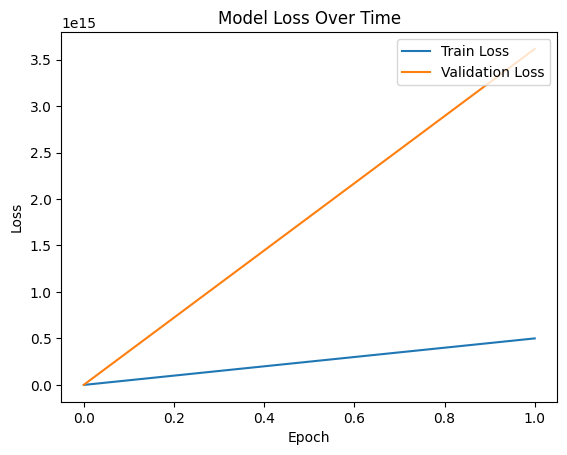

In [24]:
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

* Validation Loss > Train Loss -> Overfitting